[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cbc-univie/mdy-newanalysis-package/blob/master/docs/notebooks/msd.ipynb)

# Mean squared displacement

We calculate the mean squared displacement (msd) as well as the msdmj to obtain diffusion and conductivity.

In [2]:
import time
import sys
import numpy as np
import matplotlib.pyplot as plt

The following functions are imported from out newanalysis extension:

In [3]:
IN_COLAB = 'google.colab' in sys.modules
HAS_NEWANALYSIS = 'newanalysis' in sys.modules
if IN_COLAB:
    if not'MDAnalysis' in sys.modules:
        !pip install MDAnalysis
        import MDAnalysis
    import os
    if not os.path.exists("/content/mdy-newanalysis-package/"):
        !git clone https://github.com/cbc-univie/mdy-newanalysis-package.git
    !pwd
    if not HAS_NEWANALYSIS:
        %cd /content/mdy-newanalysis-package/newanalysis_source/
        !pip install .
    %cd /content/mdy-newanalysis-package/docs/notebooks/
#if IN_COLAB and not HAS_NEWANALYSIS:
#    !pip install "git+https://github.com/cbc-univie/mdy-newanalysis-package.git@master#egg=newanalysis&subdirectory=newanalysis_source"
else:
    try:
        import MDAnalysis
    except ModuleNotFoundError:
        !conda install --yes --prefix {sys.prefix} MDAnalysis
        import MDAnalysis
    try:
        from newanalysis.diffusion import unfoldTraj, msdCOM, msdMJ
    except ModuleNotFoundError as e:
        print("Install newanalysis fist.")
        print("Go to the newanalysis_source folder and run:")
        print("conda activate newanalysis-dev")
        print("pip install .")
        raise(e)

Install newanalysis fist.
Go to the newanalysis_source folder and run:
conda activate newanalysis-dev
pip install .


ModuleNotFoundError: No module named 'newanalysis'

## Preprocessing

Next we create our MDAnalysis Universe:

In [31]:
base='../../test_cases/data/emim_dca_equilibrium/'
psf=base+'emim_dca.psf'

skip=20
u=MDAnalysis.Universe(psf,base+"/emim_dca.dcd")
boxl = np.float64(round(u.coord.dimensions[0],4))
dt=round(u.trajectory.dt,4)

n = int(u.trajectory.n_frames/skip)
if u.trajectory.n_frames%skip != 0:
    n+=1

/home/flo/miniconda3/envs/newanalysis-dev/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Now we do the selections

In [32]:
sel_cat1  = u.select_atoms("resname EMIM")
ncat1     = sel_cat1.n_residues
com_cat1  = np.zeros((n,ncat1,3),dtype=np.float64)
print("Number EMIM   = ",ncat1)

sel_an1  = u.select_atoms("resname DCA")
nan1     = sel_an1.n_residues
com_an1  = np.zeros((n,nan1, 3),dtype=np.float64)
print("Number DCA   = ",nan1)

Number EMIM   =  1000
Number DCA   =  1000


Loop throguh the trajectory and get the center of masses

In [33]:
ctr=0
start=time.time()
print("")

for ts in u.trajectory[::skip]:
    print("\033[1AFrame %d of %d" % (ts.frame,len(u.trajectory)), "\tElapsed time: %.2f hours" % ((time.time()-start)/3600))
    com_an1[ctr] = sel_an1.center_of_mass(compound='residues')
    com_cat1[ctr]= sel_cat1.center_of_mass(compound='residues')
    ctr+=1


Frame 0 of 100 	Elapsed time: 0.00 hours
Frame 20 of 100 	Elapsed time: 0.00 hours
Frame 40 of 100 	Elapsed time: 0.00 hours
Frame 60 of 100 	Elapsed time: 0.00 hours
Frame 80 of 100 	Elapsed time: 0.00 hours


## Using newanalysis functions

We now use the unfoldTraj function to undo all jumps due to PBC. This is done in-place.

In [34]:
print("unfolding coordinates ..")
unfoldTraj(com_cat1,boxl); #; to suppress output
unfoldTraj(com_an1, boxl);

unfolding coordinates ..


Next we can calculate msd and msdmj

In [35]:
print("calculating msd ..")
msd_an1  = msdCOM(com_an1)
msd_cat1 = msdCOM(com_cat1)

#fan1=open("msd_an.dat",'w')
#fcat1=open("msd_cat.dat",'w')

#for i in range(ctr):
#    fan1.write("%5.5f\t%5.5f\n"  % (i*skip*dt, msd_an1[i]))
#    fcat1.write("%5.5f\t%5.5f\n" % (i*skip*dt, msd_cat1[i]))
    
print("calculating msdMJ ..")
msdmj = msdMJ(com_cat1,com_an1)
#f1=open("msdMJ.dat",'w')
#for i in range(ctr):
#    f1.write("%5.5f\t%5.5f\n" % (i*skip*dt, msdmj[i]))
#f1.close()

calculating msd ..
calculating msdMJ ..


## Plot the results

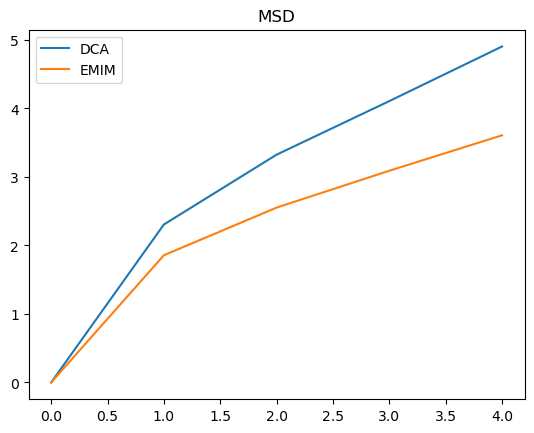

In [59]:
time = np.arange(ctr*dt)

plt.title("MSD")
plt.plot(time, msd_an1, label="DCA")
plt.plot(time, msd_cat1, label="EMIM")
plt.legend();

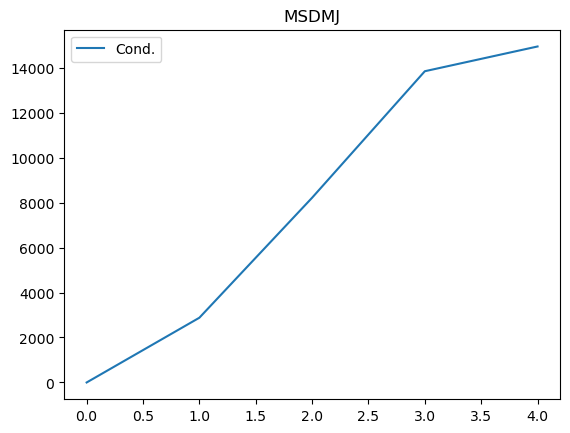

In [57]:
plt.title("MSDMJ")
plt.plot(time, msdmj, label="Cond.")
plt.legend();